In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/bigan_mnist')

models_prefix = 'models/'
images_prefix = 'images/'

if not os.path.exists(models_prefix):
  os.mkdir(models_prefix)

if not os.path.exists(images_prefix):
  os.mkdir(images_prefix)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import keras as ke
import numpy as np

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import random
from itertools import permutations

%matplotlib inline

Using TensorFlow backend.


In [3]:
epochs = 50
batch_size = 128
logging_step = 5

z_dim = 50
image_shape = (28, 28, 1)
hidden_layer_size = 1024

relu_leak = 0.2
init_lr = 0.000001

initializer = ke.initializers.RandomNormal(stddev=0.02)
regularizer = ke.regularizers.l2(2.5e-5)
optimizer = ke.optimizers.Adam(lr=init_lr, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
(X_train, y_train), (X_test, y_test) = ke.datasets.mnist.load_data()

X_train = X_train.astype(np.float32) / 255.
X_train = np.expand_dims(X_train, axis = 3)

X_test = X_test.astype(np.float32) / 255.
X_test = np.expand_dims(X_test, axis = 3)

In [0]:
def generator():
  model = ke.models.Sequential()
  
  model.add(ke.layers.Dense(hidden_layer_size, input_dim=z_dim,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.ReLU())
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.ReLU())
  model.add(ke.layers.BatchNormalization())
  
  model.add(ke.layers.Dense(np.prod(image_shape), activation='sigmoid',
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.Reshape(image_shape))
  
  return model

In [0]:
def BatchNormalization_():
  '''workaround for Keras bug, see https://github.com/keras-team/keras/issues/11927'''

  def moving_average_update(x, value, momentum):
    return x * momentum + value * (1 - momentum)

  bnorm = ke.layers.BatchNormalization() 
  bnorm_call = bnorm.call

  def wrapper(x):
    orig_tf_mau = ke.backend.moving_average_update
    ke.backend.moving_average_update = moving_average_update

    res = bnorm_call(x)

    ke.backend.moving_average_update = orig_tf_mau

    return res

  bnorm.call = wrapper
  
  return bnorm

In [0]:
def encoder():
  model = ke.models.Sequential()
  model.add(ke.layers.Flatten(input_shape=image_shape))
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.LeakyReLU(alpha=relu_leak))
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.LeakyReLU(alpha=relu_leak))
  model.add(BatchNormalization_()) # workaround
  
  model.add(ke.layers.Dense(z_dim,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))

  return model

In [0]:
def discriminator():
  z_ = ke.layers.Input(shape=(z_dim,))
  image_ = ke.layers.Input(shape=image_shape)
  input_ = ke.layers.concatenate([z_, ke.layers.Flatten()(image_)])

  model = ke.layers.Dense(hidden_layer_size,
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(input_)
  
  model = ke.layers.LeakyReLU(alpha=relu_leak)(model)
  
  model = ke.layers.Dense(hidden_layer_size,
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(model)
  
  model = ke.layers.LeakyReLU(alpha=relu_leak)(model)
  
  output = ke.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(model)

  return ke.models.Model([z_, image_], output)

In [0]:
def triplet_loss(y_true, y_pred):
    anchor = y_pred[:, :z_dim]
    positive = y_pred[:, z_dim : z_dim * 2]
    negative = y_pred[:, 2 * z_dim:]

    dist_pos = ke.backend.sum(ke.backend.square(anchor - positive), axis = 1)
    dist_neg = ke.backend.sum(ke.backend.square(anchor - negative), axis = 1)

    loss = dist_pos - dist_neg + 0.3
    
    return ke.backend.maximum(0.0, loss)

In [0]:
def build_T_bigan():
  D = discriminator()
  D.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  D.trainable = False
  
  G = generator()
  z = ke.layers.Input(shape=(z_dim, ))
  image_ = G(z)

  image = ke.layers.Input(shape=image_shape)
  image_pos = ke.layers.Input(shape=image_shape)
  image_neg = ke.layers.Input(shape=image_shape)
  
  E = encoder()
  z_ = E(image)
  z_pos = E(image_pos)
  z_neg = E(image_neg)
  
  D_real = D([z_, image])
  D_fake = D([z, image_])
  triplet = ke.layers.concatenate([z_, z_pos, z_neg])
  
  T_BiGAN = ke.models.Model([z, image, image_pos, image_neg], [D_real, D_fake, triplet])
  T_BiGAN.compile(optimizer=optimizer,
                  loss=['binary_crossentropy', 'binary_crossentropy', triplet_loss])
  
  return G, E, D, T_BiGAN

In [0]:
def load_T_bigan(G, E, D):
  z = ke.layers.Input(shape=(z_dim, ))
  image_ = G(z)

  image = ke.layers.Input(shape=image_shape)
  image_pos = ke.layers.Input(shape=image_shape)
  image_neg = ke.layers.Input(shape=image_shape)
  
  z_ = E(image)
  z_pos = E(image_pos)
  z_neg = E(image_neg)
  
  D_real = D([z_, image])
  D_fake = D([z, image_])
  triplet = ke.layers.concatenate([z_, z_pos, z_neg])
  
  T_BiGAN = ke.models.Model([z, image, image_pos, image_neg], [D_real, D_fake, triplet])
  T_BiGAN.compile(optimizer=optimizer,
                  loss=['binary_crossentropy', 'binary_crossentropy', triplet_loss])
  
  return T_BiGAN

In [12]:
LOAD_MODELS = 1

if LOAD_MODELS:
  G = ke.models.load_model(models_prefix + 'G.h5')
  E = ke.models.load_model(models_prefix + 'E.h5')
  D = ke.models.load_model(models_prefix + 'D.h5')
  T_BiGAN = load_T_bigan(G, E, D)
else:
  G, E, D, T_BiGAN = build_T_bigan()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.


In [0]:
def create_triplets(X, y, size = 100):
  triplets = []
  
  for digit in set(y):
    indices_pos = np.where(y == digit)[0]
    indices_neg = np.where(y != digit)[0]
    
    positives = random.sample(list(permutations(indices_pos, 2)), k = size)
    negatives = random.sample(list(indices_neg), k = size)
    
    for pair in positives:
      anchor = X[pair[0]]
      positive = X[pair[1]]
      
      for idx in negatives:
        negative = X[idx]
        triplets.append([anchor, positive, negative])

  return np.array(triplets)

In [0]:
def qualitative_results(n = 20):
  z = np.random.uniform(-1, 1, (n, z_dim))
  generated = G.predict(z)
  
  real_images = X_test[np.random.choice(len(X_test), n)]
  latent_codes = E.predict(real_images)
  reconstructions = G.predict(latent_codes)
  
  fig, axs = plt.subplots(3, n)
  
  for i in range(n):
    axs[0, i].imshow(generated[i, :, :, 0], cmap='gray')
    axs[1, i].imshow(real_images[i, :, :, 0], cmap='gray')
    axs[2, i].imshow(reconstructions[i, :, :, 0], cmap='gray')
    for j in range(3):
      axs[j, i].axis('off')
  
  return fig

In [0]:
def train():
  batches = int(len(X_train) / batch_size)
  
  anchors = triplets[:,0]
  positives = triplets[:,1]
  negatives = triplets[:,2]
  
  ones = np.ones(batch_size)
  zeros = np.zeros(batch_size)
  dummy = np.empty(batch_size)

  for epoch in range(epochs):
    for batch in range(batches):
      indices = np.random.choice(len(triplets), batch_size)
      z = np.random.uniform(-1, 1, (batch_size, z_dim))
      
      images = anchors[indices]
      images_pos = positives[indices]
      images_neg = negatives[indices]
      
      z_ = E.predict(images)
      images_ = G.predict(z)

      loss_D_fake = D.train_on_batch([z, images_], zeros)
      loss_D_real = D.train_on_batch([z_, images], ones)
      loss_T_E_G = T_BiGAN.train_on_batch([z, images, images_pos, images_neg], [zeros, ones, dummy])
      
    if epoch % logging_step == 0:
      D_loss = (loss_D_fake[0] + loss_D_real[0]) * 0.5
      acc_fake = loss_D_fake[1] * 100.0
      acc_real = loss_D_real[1] * 100.0
      loss_E_G = loss_T_E_G[1] + loss_T_E_G[2]
      loss_T   = loss_T_E_G[3]
      
      print('[Epoch {}] (Disc loss: {:.2f}, acc_fake: {:.1f}%, acc_real: {:.1f}%) (E_G loss: {:.2f}) (T loss: {:.3f})'.
            format(epoch, D_loss, acc_fake, acc_real, loss_E_G, loss_T))
      
      fig = qualitative_results()
      fig.savefig('images/T_{}.png'.format(epoch))
      plt.close()

In [0]:
TRAIN_MODELS = 0

if TRAIN_MODELS:
  triplets = create_triplets(X_train, y_train)
  print('Triplets shape: {}'.format(triplets.shape))
  train()

In [0]:
SAVE_MODELS = 0

if SAVE_MODELS:
  G.save(models_prefix + 'T_G.h5')
  E.save(models_prefix + 'T_E.h5')
  D.save(models_prefix + 'T_D.h5')

In [0]:
def ONN_accuracy():
  latent_codes = E.predict(X_test)
  ONN = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(latent_codes)
  
  _, indices = ONN.kneighbors(latent_codes)
  results = (y_test == y_test[indices[:,1]])
  
  print('One Nearest Neighbors (1NN) classification accuracy: {}%'.format(100. * np.mean(results)))

In [0]:
def TSNE_embedding(X, y, n):
  latent_codes = E.predict(X[:n])
  embedding = TSNE().fit_transform(latent_codes)
  
  ax = plt.subplot(1, 1, 1)
  ax.scatter(embedding[:, 0], embedding[:, 1], c=y[:n], cmap=plt.cm.get_cmap('RdYlBu'))
  ax.axis('off')
  
  plt.show()

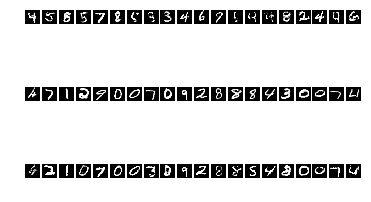

One Nearest Neighbors (1NN) classification accuracy: 95.43%


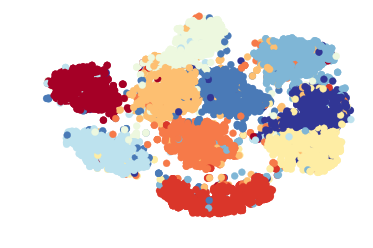

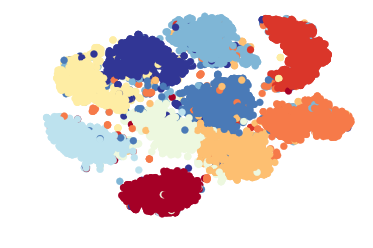

In [20]:
EVALUATE_MODELS = 1

if EVALUATE_MODELS:
  qualitative_results()
  plt.show()
  
  ONN_accuracy()
  
  TSNE_embedding(X_train, y_train, len(y_test))
  TSNE_embedding(X_test, y_test, len(y_test))